In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from DataSplit import *
from PCA import *
from RMSE import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('default')
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi1.png', dpi = 200, bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 14, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi2.png', dpi = 200, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(14, 21, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper left', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi3.png', dpi = 200, bbox_inches='tight')
    plt.show()
    return 0

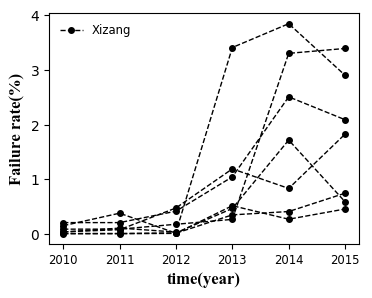

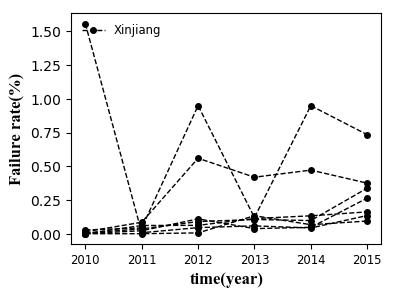

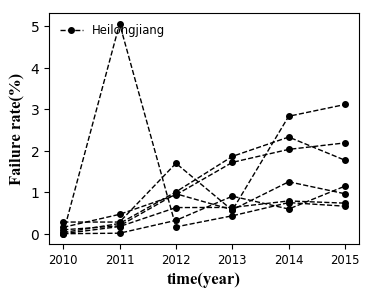

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])

# #特征因素分析
elec_tem = elec_data.Tem.values + SNR[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
elec_year_Mean = (elec_year - np.mean(elec_year)) #均值化后的时间点

# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char1 = np.loadtxt('elec_Pca_char1.csv',delimiter = ',')
# elec_Pca_char2 = np.loadtxt('elec_Pca_char2.csv',delimiter = ',')

elec_data.Fault.values[48] =1200
elec_data.Fault.values[85] =700
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(elec_year))
Num_shared = shared(np.asarray(companyABC))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)

def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

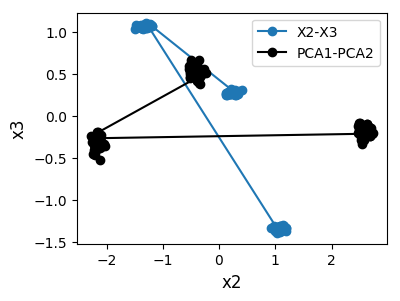

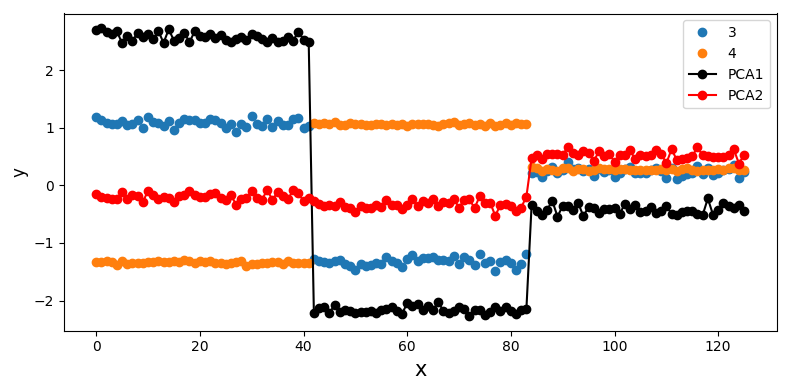

In [4]:
from matplotlib import gridspec
# 最后两个变量因素的主成分最大。故只画出最后两个的图
fig = plt.figure(figsize=(4, 3))
gs = gridspec.GridSpec(1, 2)
ip=1
# ax = plt.subplot(gs[ip])
ax = plt.subplot(1, 1, 1)
ax.plot(elec_Pca[:, 2],elec_Pca[:, 3],'o-')

ax.plot(elec_Pca1[:, 0], elec_Pca1[:, 1], 'ko-')
plt.legend([ 'X2-X3', 'PCA1-PCA2'], loc='upper right')
    
plt.xlabel('x2', fontsize=12)
plt.ylabel('x3', fontsize=12)
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Corr.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 1)
for ip in np.arange(1):
    ax = plt.subplot(gs[ip])
    for i in np.arange(2):
        ax.plot(elec_Pca[:, (i+2)],'o')

    ax.plot(elec_Pca1[:, ip], 'ko-')
    ax.plot(elec_Pca1[:, ip+1], 'ro-')
    plt.legend([ '3', '4', 'PCA1','PCA2'], loc='upper right')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
# 建模，模型
with pm.Model() as model_1:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', 10)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', 10)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', 10)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', 10)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd = pm.InverseGamma('sd',3, 0.0001)
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Uniform('u', lower=0,upper=3 )
        
    beta_mu = pm.Deterministic('beta_mu', tt.exp( u*(tt.sqrt(beta1[Num_shared]**2 + beta4[Num_shared]**2)) + beta + \
                                             (beta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                              beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_year * xs_year)))

    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值
    trace_1 = pm.sample(3000,  init='advi+adapt_diag' )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 92.247:  15%|███████▊                                           | 30626/200000 [00:35<03:16, 862.78it/s]
Convergence archived at 30700
Interrupted at 30,699 [15%]: Average Loss = 3.6491e+62
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [02:10<00:00, 26.88it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 434 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|████████████████████████████████████████████

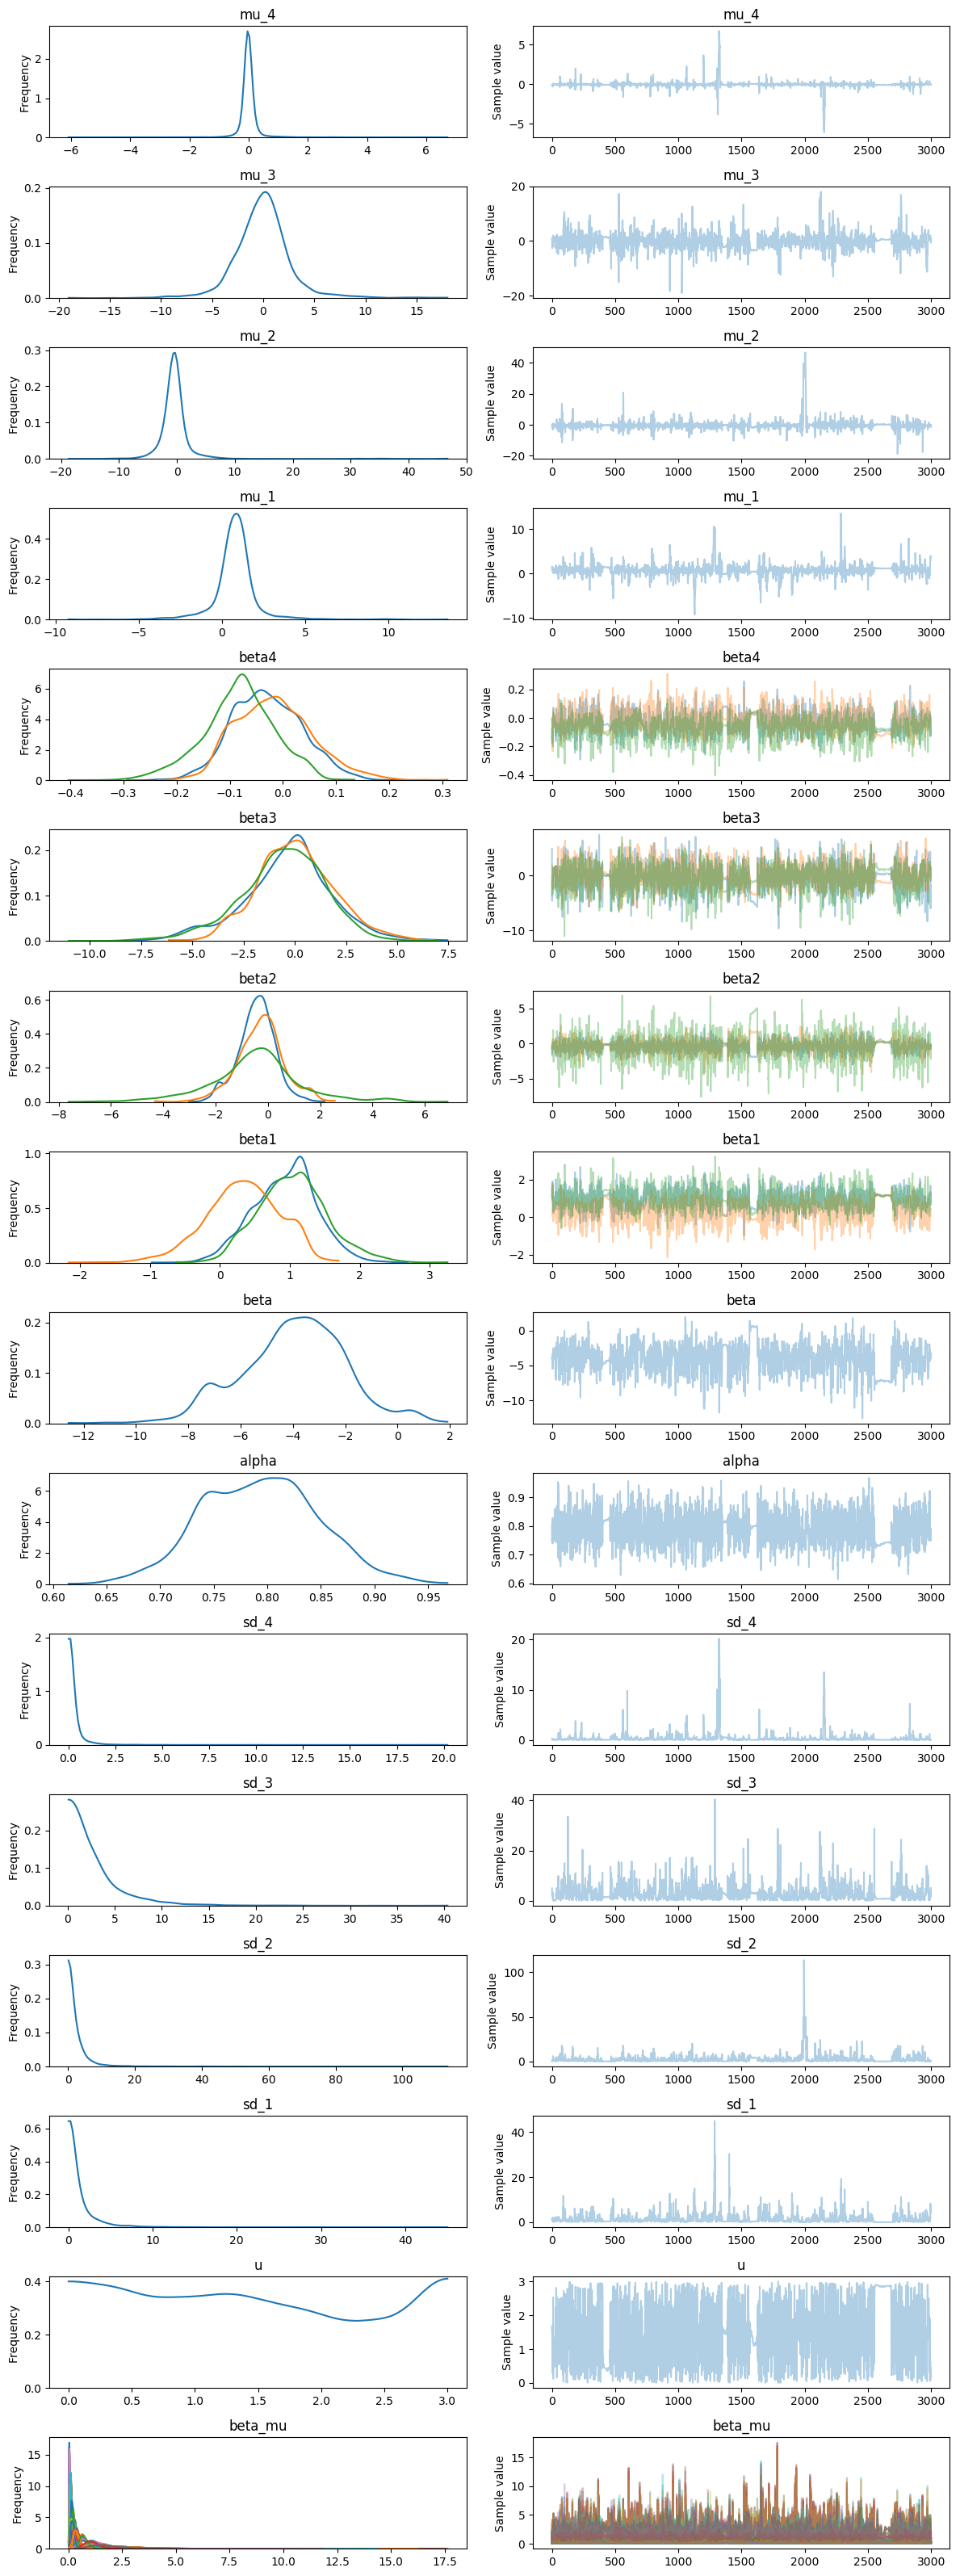

In [6]:
pm.traceplot(trace_1)
plt.show()

In [7]:
burnin = 2000
chain = trace_1[burnin:]
# get MAP estimate
varnames2 = ['beta', 'beta1', 'beta2', 'beta3','beta4', 'u']
tmp = pm.df_summary(chain, varnames2)
betaMAP = tmp['mean'][0]
beta1MAP = tmp['mean'][np.arange(companiesABC) + 1]
beta2MAP = tmp['mean'][np.arange(companiesABC) + 1*companiesABC+1]
beta3MAP = tmp['mean'][np.arange(companiesABC) + 2*companiesABC+1]
beta4MAP = tmp['mean'][np.arange(companiesABC) + 3*companiesABC+1]
uMAP = tmp['mean'][4*companiesABC+1]
print(uMAP)

1.6605539556446716


In [8]:
varnames3 = ['beta_mu']
tmp_mu = pm.df_summary(chain, varnames3)
Beta_Mu = tmp_mu['mean']

Beta_Mu2 = np.array([Beta_Mu[i*6:(i+1)*6] for i in np.arange(21)])

# print(Beta_Mu2)

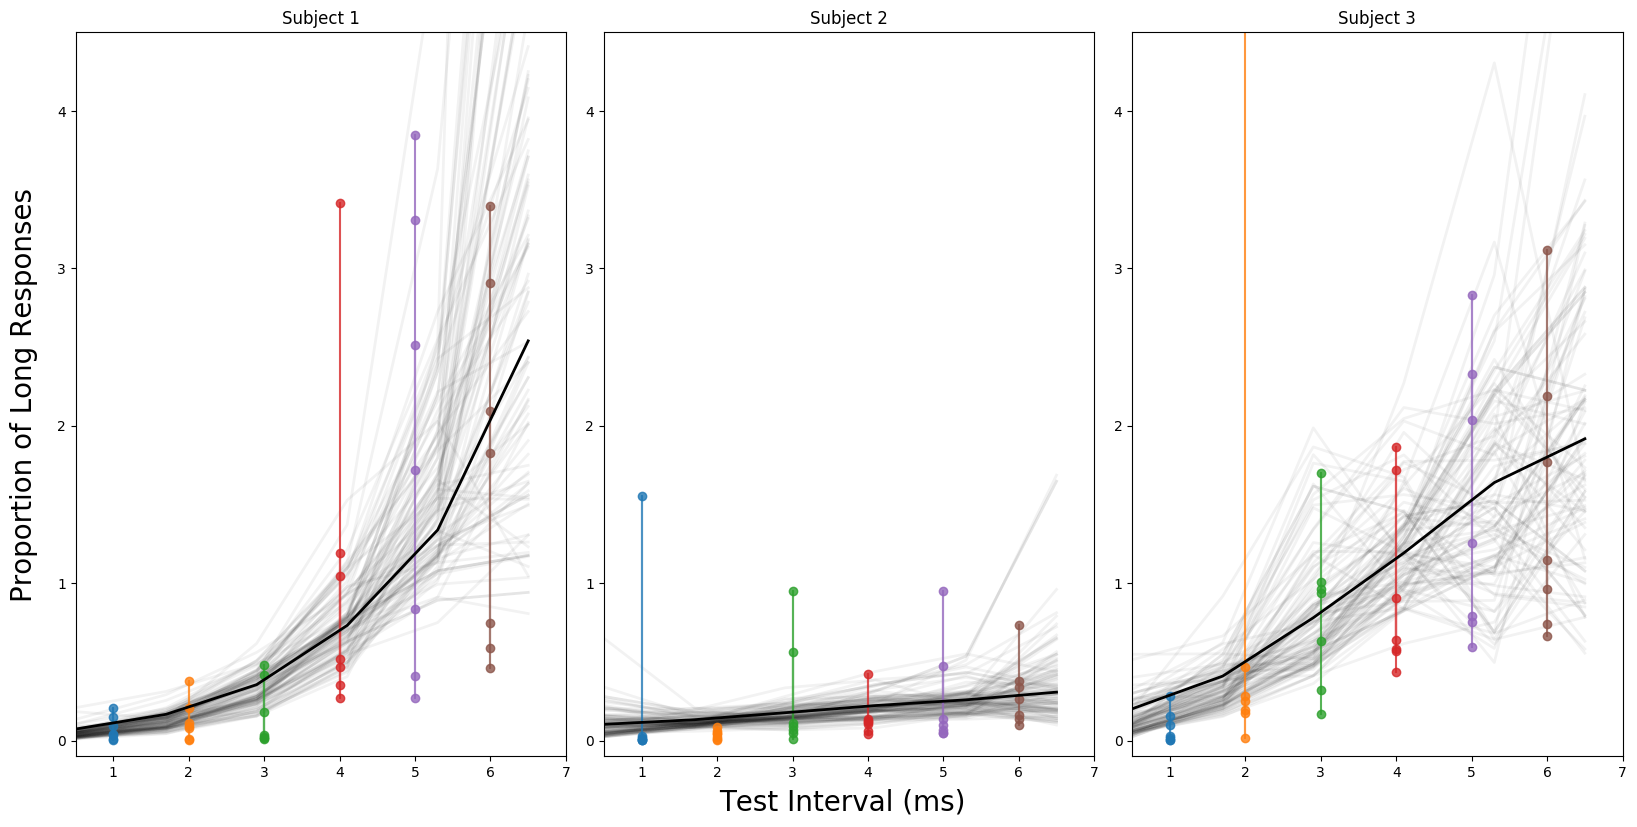

In [9]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    

    xl = np.linspace(0.5, 6.5, 6)
    yl = Beta_Mu2[ip*7:(ip+1)*7, :]
    yl = yl.mean(axis=0)
     
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_1[ips]
        yl2 = np.exp(param['u']*(np.sqrt(param['beta1'][ip]**2 + param['beta4'][ip]**2)) + param['beta'] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
    xl = np.linspace(0.5, 6.5, 6)
    plt.plot(xl, yl, 'k-', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [11]:
# print(Beta_Mu_2b)
ip = 0
yipred_yplot = Beta_Mu2[7*ip:(ip+1)*7, ]
Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_A)
ip = 1
yipred_yplot = Beta_Mu2[7*ip:(ip+1)*7, ]
Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_B)
ip = 2
yipred_yplot = Beta_Mu2[7*ip:(ip+1)*7, ]
Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_C)

M0_Mean_output = np.vstack((Pred_yplot_Mean_A, Pred_yplot_Mean_B, Pred_yplot_Mean_C))
print(M0_Mean_output)
# np.savetxt('M0_Mean_output.csv', M0_Mean_output, delimiter = ',')

[0. 0. 0. 1. 1. 3.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 2. 2.]
[[0. 0. 0. 1. 1. 3.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 2. 2.]]


In [18]:
# 第七年数据测试，读取测试数据集特征,
data_cs = pd.read_csv('XZ_CS.csv')
SNR_cs = np.random.normal(0, 2, size=[len(data_cs.Tem.values), 4])
datax_cs = np.array(data_cs)[:,0:4] + SNR_cs # 添加噪声

data_cs_year = data_cs.Year.values # 测试数据时间
data_cs_num  = data_cs.Count.values # 测试数据参考位置,这么做就是整数

meanVal = np.mean(datax_cs, axis=0)  # 按列求均值，即求各个特征的均值
newData_mean = datax_cs - meanVal
StdVal  = np.std(datax_cs, axis=0)
newData_std = newData_mean/StdVal


pca = PCA(n_components=2)
pca.fit(newData_std)
Pca_cs = pca.transform(newData_std) # 测试数据PCA特征值，直接调用即可，但是之调用这条也会出问题
Pca_cs_char1 = Pca_cs[:, 0]
Pca_cs_char2 = Pca_cs[:, 1]
print(data_cs_year)
print(data_cs_num)
# print(Pca_cs)

# print(pm.waic(trace, model1))

[1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2
 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4
 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6
 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 3657.57it/s]


[0. 0. 0. 1. 2. 3. 8.]


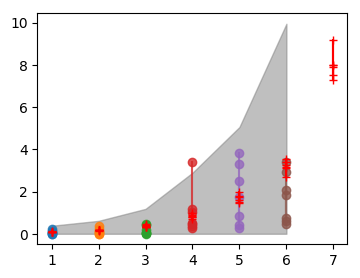

[0. 0. 0. 0. 0. 0. 0.]


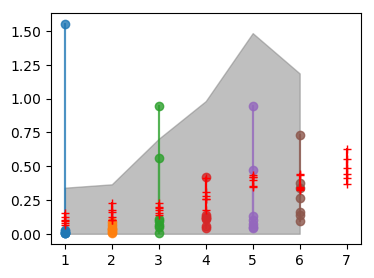

[0. 0. 1. 1. 2. 2. 2.]


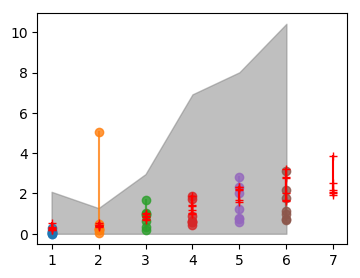

[[0. 0. 0. 1. 2. 3. 8.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 2. 2. 2.]]


In [26]:
# 测试数据结果显示
# print(data_cs_year)
xs_year.set_value(np.asarray(data_cs_year))
Num_shared.set_value(np.asarray(data_cs_num))
xs_char1.set_value(np.asarray(Pca_cs_char1))
xs_char2.set_value(np.asarray(Pca_cs_char2))

with model_1:
    ppcc = pm.sample_ppc(trace_1)
post_pred = ppcc['Observed']
yipred_mean = post_pred.mean(axis=0)
# print(yipred_mean)
# idx = data_cs_year # 这句话要改
sig0 = pm.hpd(post_pred, alpha=0.05)
# plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
# print(sig0)
# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
xipred={}

fig = plt.figure(figsize=(4, 3))
# fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 0
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[:6,0], sig0[:6,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
M1_Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
print(M1_Pred_yplot_Mean_A)
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 1
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[42:48,0], sig0[42:48,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
M1_Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
print(M1_Pred_yplot_Mean_B)
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 2
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[84:90,0], sig0[84:90,1], color='gray', alpha=.5)  

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
M1_Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
print(M1_Pred_yplot_Mean_C)
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
plt.show()

M1_Pred_y_Mean = np.vstack((M1_Pred_yplot_Mean_A, M1_Pred_yplot_Mean_B, M1_Pred_yplot_Mean_C))
print(M1_Pred_y_Mean)

In [27]:
Pred_y_Mean = M1_Pred_y_Mean[:,-1]
print(Pred_y_Mean)

Pred_Data = pd.read_csv('XZmulti_6_Only7Test.csv')
Pred_faults = 100 * (Pred_Data.Fault.values / Pred_Data.Nums.values)  # 数组形式,计算故障率大小

AAAA = RMSEfor_Pred(Pred_faults, Pred_y_Mean)
print(AAAA)

[8. 0. 2.]
Rmse Mean is A、B、C :
{0: 0.054599962576501855, 1: 0.002675254627532784, 2: 0.009883908424616642}


模型2
===

In [10]:
X = np.vstack((elec_year, elec_Pca_char1, elec_Pca_char2, companyABC)).T
Y = elec_faults
X_train, X_test, Y_train, Y_test = DataSplit(X, Y, test_size=.2) #随机分离原始数据
print(np.shape(X_train))
# print(Y_train)
X_train_M1_year = elec_year[0:len(X_train)] #防止变为浮点数
X_train_M1_char1 = X_train[:, 1]
X_train_M1_char2 = X_train[:, 2]
X_train_M1_ABC = X_train[:, 3]
X_train_M1_ABC =[int(i) for i in X_train_M1_ABC] #防止变为浮点数
M2_companyABC = np.array(X_train_M1_ABC)

Y_train_M1_faults = Y_train


# 共享变量设置
M2_xs_char1 = shared(np.asarray(elec_Pca_char1))
M2_xs_char2 = shared(np.asarray(elec_Pca_char2))

M2_ys_faults = shared(np.asarray(elec_faults))
M2_xs_year = shared(np.asarray(elec_year))
M2_Num_shared = shared(np.asarray(companyABC))
M2_companyABC = companyABC

# xs_char1 = shared(np.asarray(elec_Pca_char1))
# xs_char2 = shared(np.asarray(elec_Pca_char2))

# ys_faults = shared(np.asarray(elec_faults))
# xs_year = shared(np.asarray(elec_year))
# Num_shared = shared(np.asarray(companyABC))
print(X_train_M1_year)
print(np.shape(M2_companyABC))

[ 0  5  8 13 17 19]
(90, 4)
[1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1
 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2
 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6]
(126,)


In [11]:
# 建模，加上含污染模型对比
with pm.Model() as model_2:
    # define priors
    sdsd = 3
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', sdsd)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', sdsd)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', sdsd)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', sdsd)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd_0 = pm.HalfCauchy('sd_0', 20)
#     sd = pm.InverseGamma('sd',3, 0.0001)
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Uniform('u', lower=0,upper=3 )

    liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M2_Num_shared]**2 + beta4[M2_Num_shared]**2)) + beta + \
                                             (beta1[M2_Num_shared] * M2_xs_year + beta2[M2_Num_shared] * M2_xs_char1 +\
                                              beta3[M2_Num_shared] * M2_xs_char2 + beta4[M2_Num_shared] * M2_xs_year * M2_xs_year)))

    # latent model for contamination
#     upper = pm.HalfCauchy('upper', 10)
    sigma_p = pm.HalfCauchy('sigma_p', sdsd)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M2_Num_shared.get_value()))
    
    zij_ = pm.theanof.tt_rng().uniform(size=M2_companyABC.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[M2_Num_shared]))   

    beta_mu = pm.Deterministic('beta_mu', tt.switch(zij, liner, pi_ij))
    
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=M2_ys_faults)  # 观测值

import theano
with model_2:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_2 = approx.sample(3000, include_transformed=True)
    elbos1 = -inference.hist

Average Loss = 141.18: 100%|████████████████████████████████████████████████████| 20000/20000 [00:34<00:00, 580.64it/s]
Finished [100%]: Average Loss = 140.98
Average Loss = 114.4: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 872.11it/s]
Finished [100%]: Average Loss = 114.37


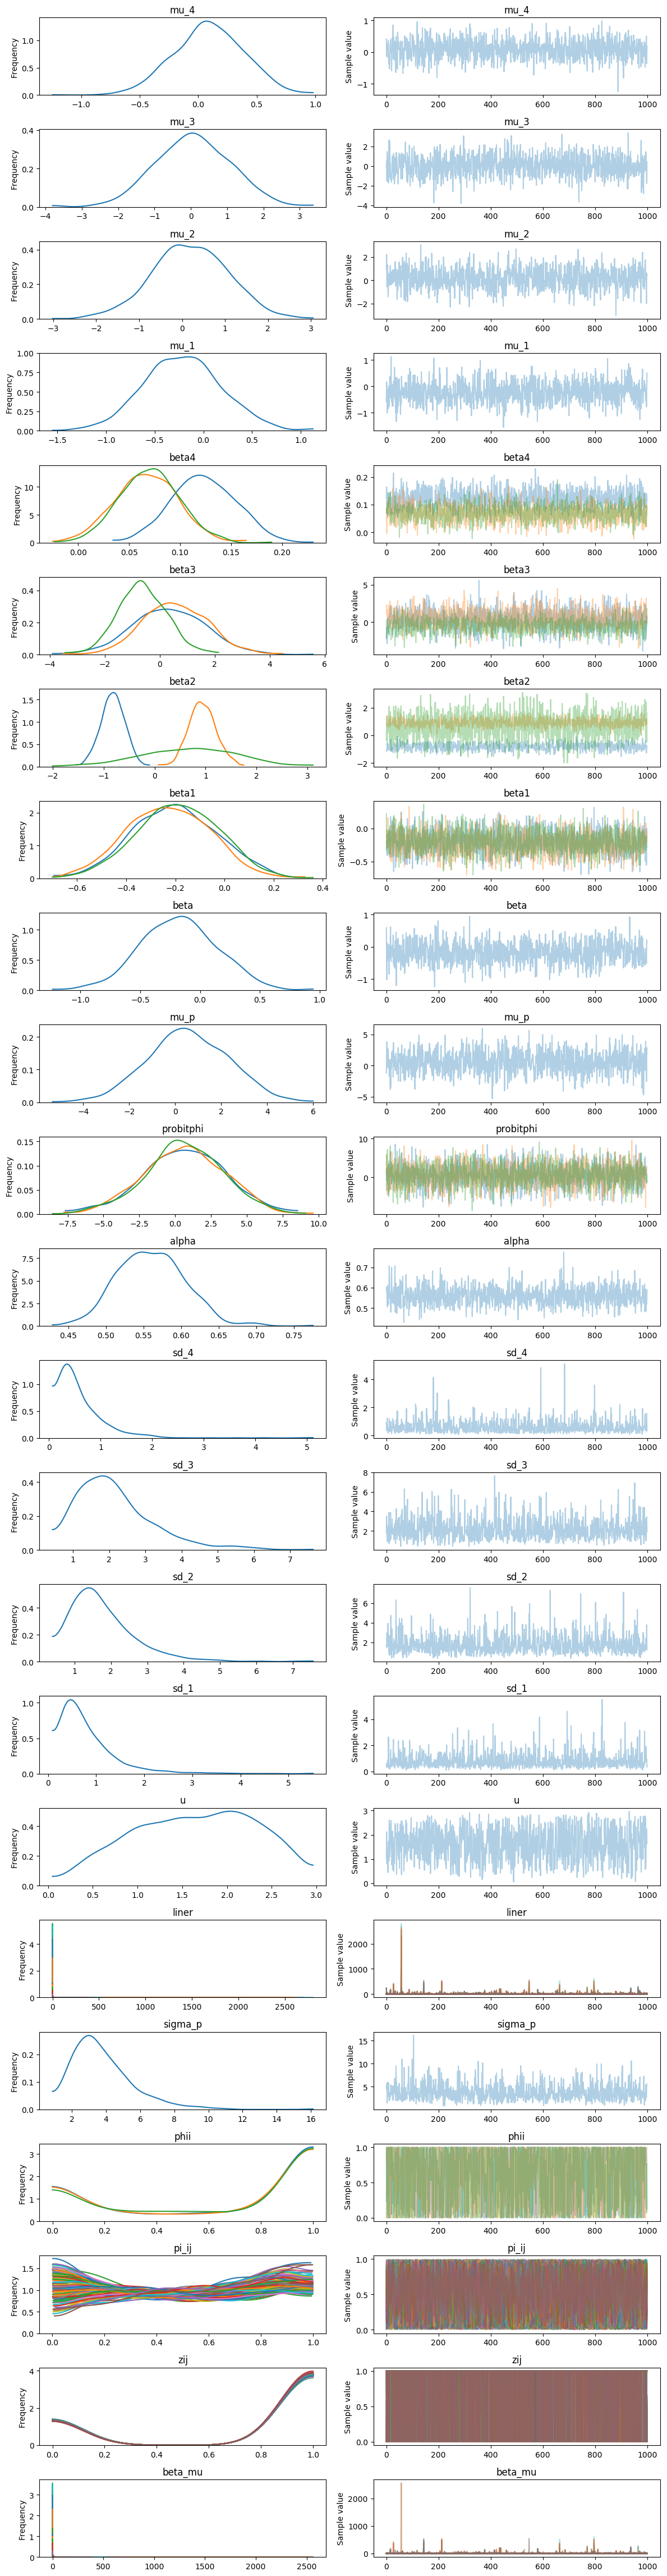

In [12]:
chain_2 = trace_2[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_2)
plt.show()

In [13]:
njob = 1
start = trace_2[0]
start['zij'] = start['zij'].astype(int)
stds = approx.bij.rmap(approx.std.eval())
cov = model_2.dict_to_array(stds) ** 2
# 建模，加上含污染模型对比
with pm.Model() as model_2b:
    # define priors
    sdsd = 3
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', sdsd)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', sdsd)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', sdsd)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', sdsd)
    #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
    #     sd_0 = pm.HalfCauchy('sd_0', 20)
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Uniform('u', lower=0,upper=3 )

    liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M2_Num_shared]**2 + beta4[M2_Num_shared]**2)) + beta + \
                                             (beta1[M2_Num_shared] * M2_xs_year + beta2[M2_Num_shared] * M2_xs_char1 +\
                                              beta3[M2_Num_shared] * M2_xs_char2 + beta4[M2_Num_shared] * M2_xs_year * M2_xs_year)))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M2_Num_shared.get_value()))

    # latent model for contamination
    sigma_p = pm.HalfCauchy('sigma_p', sdsd)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))

    zij = pm.Bernoulli('zij', p=phii[M2_Num_shared], shape=len(M2_Num_shared.get_value()))

    beta_mu = pm.Deterministic('beta_mu', tt.switch(tt.eq(zij, 0), liner, pi_ij))

    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=M2_ys_faults)  # 观测值

    #     step1 = pm.Metropolis([zij])
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace_2b = pm.sample(3000, step=[step], start=start, njobs=njob, turn=500)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [04:24<00:00, 13.23it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 367 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [04:24<00:00, 13.23it/s]


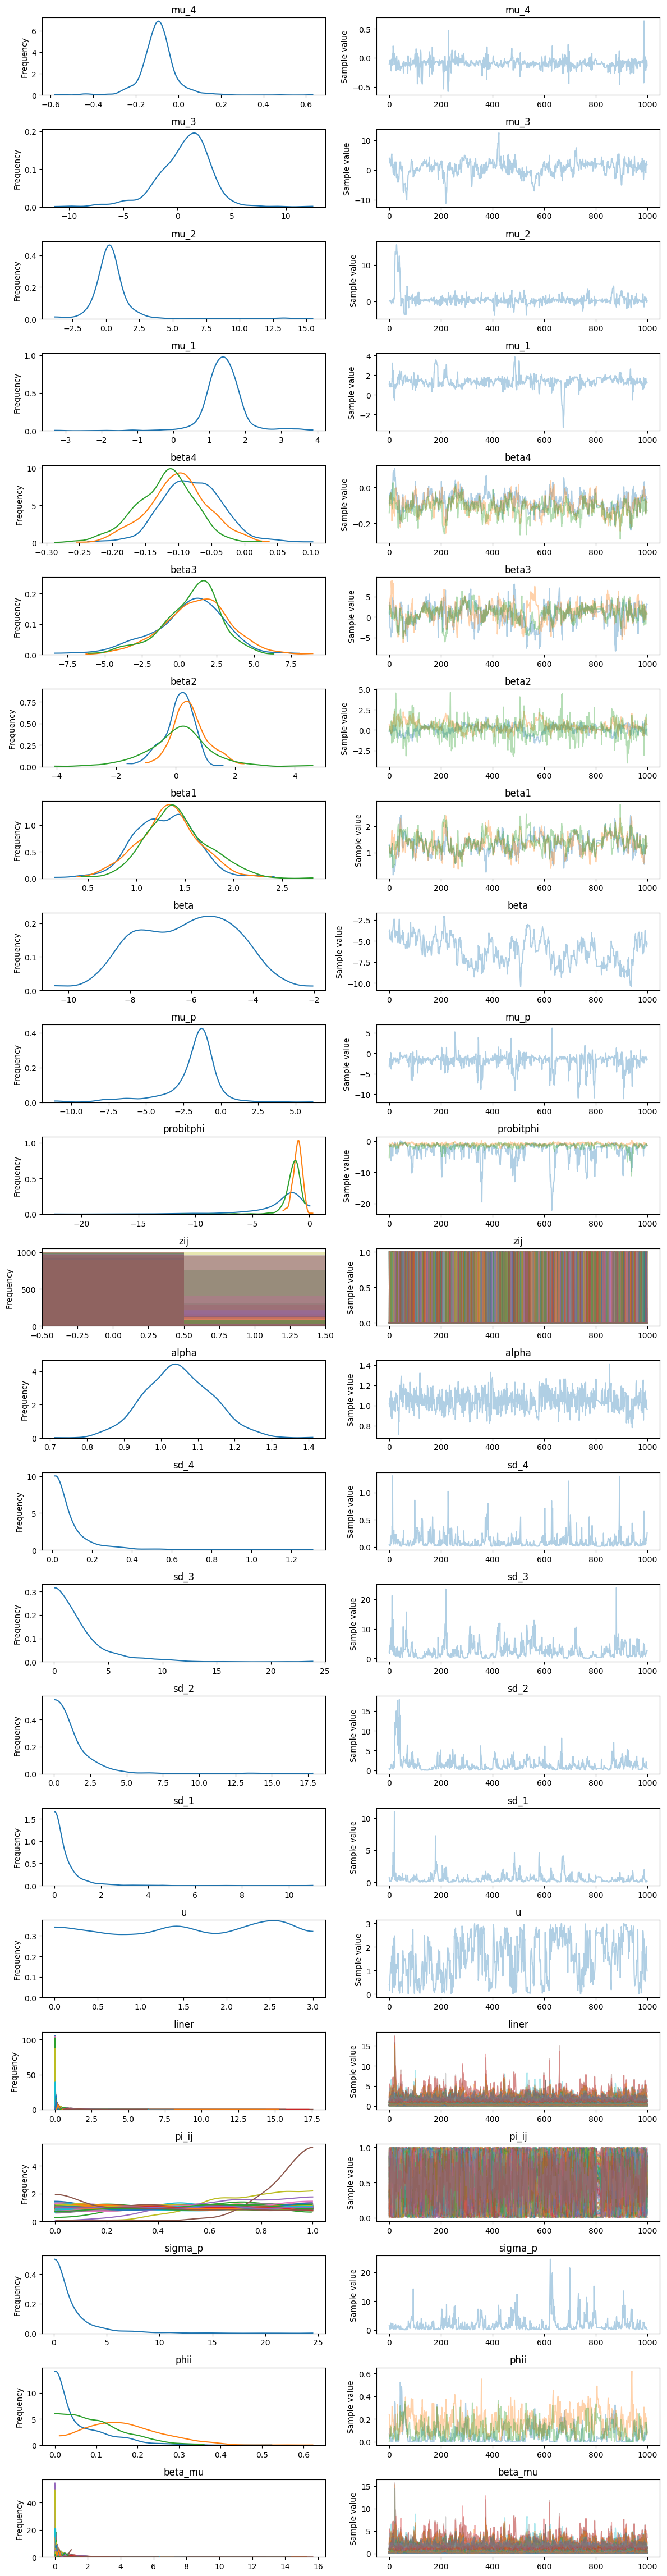

In [14]:
chain_2b = trace_2b[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_2b)
plt.show()

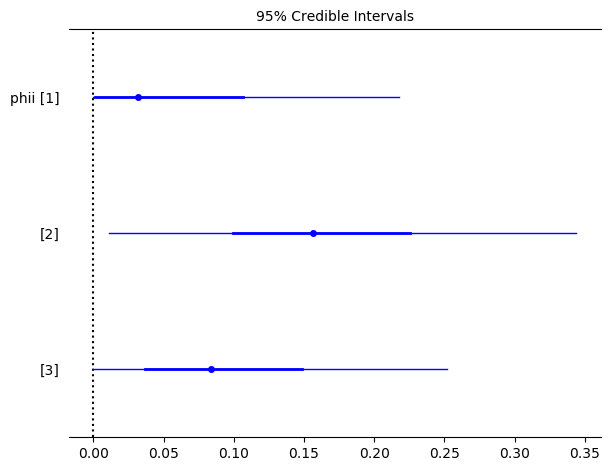

In [15]:
pm.forestplot(trace_2b, varnames=['phii'])
plt.show()

In [16]:
varnames2bb = ['beta1','beta2','beta3']
# varnames2b = ['beta_mu']
print(pm.df_summary(chain_2b, varnames2bb))
varnames2b = ['liner']
# varnames2b = ['beta_mu']
tmp_mu2b = pm.df_summary(chain_2b, varnames2b)
Beta_Mu2b = tmp_mu2b['mean']

Beta_Mu_2b = np.array([Beta_Mu2b[i*6:(i+1)*6] for i in np.arange(21)])
# Beta_Mu_2b = np.array([Beta_Mu2b[i*6:(i+1)*6] for i in np.arange(21)])
# Beta_Mu_2bb = np.array(Beta_Mu2b.mean)
# print(Beta_Mu2b)


              mean        sd  mc_error   hpd_2.5  hpd_97.5
beta1__0  1.295176  0.323934  0.026326  0.670701  1.920611
beta1__1  1.328858  0.319904  0.025421  0.645019  1.912778
beta1__2  1.420408  0.324171  0.025348  0.844750  2.112575
beta2__0  0.085625  0.507504  0.043916 -0.995172  0.903318
beta2__1  0.488121  0.583752  0.047203 -0.480790  1.872555
beta2__2  0.115727  1.072178  0.061661 -2.140136  2.239302
beta3__0  0.565749  2.477945  0.180865 -4.429280  5.063740
beta3__1  1.145328  2.237591  0.175198 -3.194899  5.726624
beta3__2  0.807877  1.952437  0.162619 -3.951637  4.100820


In [17]:
# 将故障率以5组一行形式组成数组,变成：21*6
M2_elec_faults2 = np.array([Y_train_M1_faults[i*6:(i+1)*6] for i in np.arange(21)])
M2_elec_year2 = np.array([X_train_M1_year[i*6:(i+1)*6] for i in np.arange(21)])
M2_elec_char1 = np.array([X_train_M1_char1[i*6:(i+1)*6] for i in np.arange(21)])
M2_elec_char2 = np.array([X_train_M1_char2[i*6:(i+1)*6] for i in np.arange(21)])

In [18]:
# print(Beta_Mu_2b)
ip = 0
yipred_yplot = Beta_Mu_2b[7*ip:(ip+1)*7, ]
Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_A)
ip = 1
yipred_yplot = Beta_Mu_2b[7*ip:(ip+1)*7, ]
Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_B)
ip = 2
yipred_yplot = Beta_Mu_2b[7*ip:(ip+1)*7, ]
Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_C)

M0_Mean_output = np.vstack((Pred_yplot_Mean_A, Pred_yplot_Mean_B, Pred_yplot_Mean_C))
print(M0_Mean_output)
# np.savetxt('M0_Mean_output.csv', M0_Mean_output, delimiter = ',')

[0. 0. 0. 1. 2. 3.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 2. 2.]
[[0. 0. 0. 1. 2. 3.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 2. 2.]]


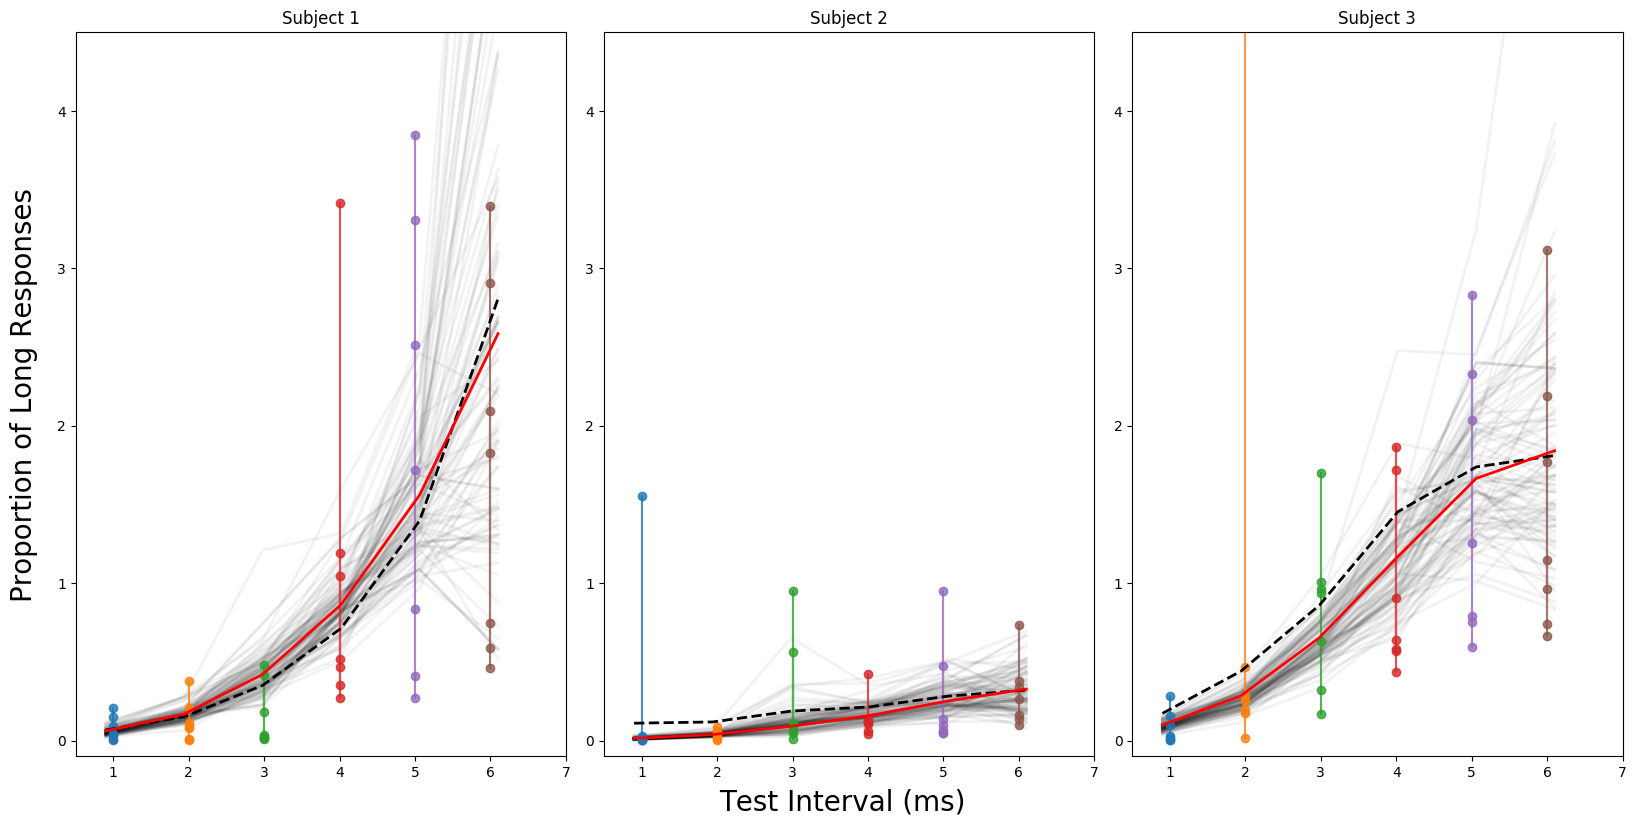

In [19]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    

    xl = np.linspace(0.9, 6.1, 6)
    yl = Beta_Mu2[ip*7:(ip+1)*7, :]
    yl = yl.mean(axis=0)
    
#     y2 = Beta_Mu_2b[ip*7:(ip+1)*7, :]
#     y2 = y2.mean(axis=0)
    y2 = M0_Mean_output[ip]
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_2b[ips]
        yl2 = np.exp(param['u']*(np.sqrt(param['beta1'][ip]*param['beta1'][ip] + param['beta4'][ip]**2)) + param['beta'] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, yl, 'k--', linewidth=2)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()


In [20]:
# 预测值输出的均值
Mean_output =[]
Mean_output2b =[]
for ip in np.arange(3):
    y1 = Beta_Mu2[ip*7:(ip+1)*7, :]
    y1 = y1.mean(axis=0)
    
    Mean_output.append(y1)
    
    y2 = Beta_Mu_2b[ip*7:(ip+1)*7, :]
    y2 = y2.mean(axis=0)
    Mean_output2b.append(y2)
    
print(Mean_output)
print(Mean_output2b)
Rmse_all = RMSE(elec_faults, Mean_output, Len_One=6, Zoom_factor=100)
print(Rmse_all)
Mse_all = MSE(elec_faults, Mean_output, Len_One=6, Zoom_factor=100)
print(Mse_all)

Rmse_all2b = RMSE(elec_faults, Mean_output2b, Len_One=6, Zoom_factor=100)
print(Rmse_all2b)
Mse_all2b = MSE(elec_faults, Mean_output2b, Len_One=6, Zoom_factor=100)
print(Mse_all2b)

[array([0., 0., 0., 1., 1., 3.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 2., 2.])]
[array([0., 0., 0., 1., 2., 3.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 2., 2.])]
Rmse Mean is A、B、C :
{0: 0.009098307934541047, 1: 0.009982830807238443, 2: 0.00840966345328109}
Mse Mean is A、B、C :
{0: 9.227342990102597e-05, 1: 0.0001512271226788416, 2: 7.983023629021543e-05}
Rmse Mean is A、B、C :
{0: 0.008518621240864268, 1: 0.010117940086845243, 2: 0.00781835014957213}
Mse Mean is A、B、C :
{0: 8.231284516463692e-05, 1: 0.0001543667493063825, 2: 7.224810819005521e-05}


In [21]:
WAIC = pm.compare([trace_1, trace_2b], [model_1, model_2b], ic='WAIC')
print(WAIC)

    WAIC  pWAIC  dWAIC weight     SE    dSE warning
1  -3.07  19.96      0      1  40.37      0       1
0  49.05  15.31  52.12      0  44.15  16.72       1


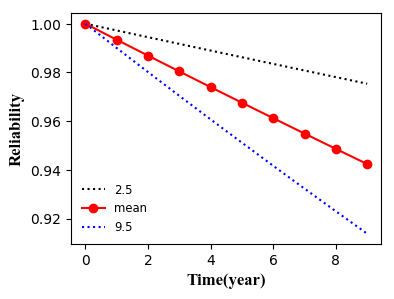

In [22]:
# 可靠度计算，beta_mu要除以100还原
post_alpha1 = np.mean(chain_2b['alpha'])
post_beta_mu1 = np.mean(chain_2b['beta_mu'])/100

varnames1 = ['alpha', 'beta_mu']
aaa1 = pm.df_summary(trace_2b, varnames1)
bbb1 = pd.DataFrame(aaa1)

hpdd2_5 = bbb1['hpd_2.5']
hpdd97_5 = bbb1['hpd_97.5']
hpd2_5_alpha = hpdd2_5[:1].mean()
hpd97_5_alpha = hpdd97_5[:1].mean()
hpd25_beta_mu = hpdd2_5[1:].mean()/100
hpd975_beta_mu = hpdd97_5[1:].mean()/100

# 可靠度函数：这里为故障度函数
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
t = np.arange(0, 10, 1)
R1 = np.exp(-((t/post_beta_mu1)**post_alpha1))
R2 = np.exp(-((t/hpd25_beta_mu)**hpd2_5_alpha))
R3 = np.exp(-((t/hpd975_beta_mu)**hpd97_5_alpha))
# plt.plot(t, R2, 'k:', t, R1, 'bo-', t, R3, 'r:')
# 需要进行转换以进行可靠度分析，依据书71页的表达式，可反推出可靠度函数
R11 = np.exp(-((t/post_alpha1)*post_beta_mu1))
R22 = np.exp(-((t/hpd2_5_alpha)*hpd25_beta_mu))
R33 = np.exp(-((t/hpd97_5_alpha)*hpd975_beta_mu))
plt.plot(t, R22, 'k:', t, R11, 'ro-', t, R33, 'b:')
# ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'], fontsize='small')
ax.set_xlabel("Time(year)", fontdict=font1)
plt.ylabel("Reliability", fontdict=font1)
# plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
ax.legend(['2.5','mean','9.5'], loc='lower left',frameon=False, fontsize='small')

plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Reliability.png', dpi = 200, bbox_inches='tight')
plt.show()

In [3]:
# 第七年数据测试，读取测试数据集特征,
data_cs = pd.read_csv('XZ_CS.csv')
SNR_cs = np.random.normal(0, 2, size=[len(data_cs.Tem.values), 4])
datax_cs = np.array(data_cs)[:,0:4] + SNR_cs # 添加噪声

data_cs_year = data_cs.Year.values # 测试数据时间
data_cs_num  = data_cs.Count.values # 测试数据参考位置,这么做就是整数

meanVal = np.mean(datax_cs, axis=0)  # 按列求均值，即求各个特征的均值
newData_mean = datax_cs - meanVal
StdVal  = np.std(datax_cs, axis=0)
newData_std = newData_mean/StdVal


pca = PCA(n_components=2)
pca.fit(newData_std)
Pca_cs = pca.transform(newData_std) # 测试数据PCA特征值，直接调用即可，但是之调用这条也会出问题
Pca_cs_char1 = Pca_cs[:, 0]
Pca_cs_char2 = Pca_cs[:, 1]
print(data_cs_year)
print(data_cs_num)
# print(Pca_cs)

# print(pm.waic(trace, model1))

NameError: name 'pd' is not defined

In [4]:
# 测试数据结果显示
# print(data_cs_year)
M2_xs_year.set_value(np.asarray(data_cs_year))
M2_Num_shared.set_value(np.asarray(data_cs_num))
M2_xs_char1.set_value(np.asarray(Pca_cs_char1))
M2_xs_char2.set_value(np.asarray(Pca_cs_char2))

with model_2b:
    ppcc = pm.sample_ppc(trace_2b)
post_pred = ppcc['Observed']
yipred_mean = post_pred.mean(axis=0)
# print(yipred_mean)
# idx = data_cs_year # 这句话要改
sig0 = pm.hpd(post_pred, alpha=0.05)
# plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
# print(sig0)
# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
xipred={}

fig = plt.figure(figsize=(4, 3))
# fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 0
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[:6,0], sig0[:6,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 1
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[42:48,0], sig0[42:48,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 2
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[84:90,0], sig0[84:90,1], color='gray', alpha=.5)  

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
plt.show()

NameError: name 'M2_xs_year' is not defined